# Booking reviews competition

## Description

Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

Нам поставлена задача создать такую модель.

Тестовая выборка представлена в LeaderBoard целиком.

Делаем реальный ML продукт, который потом сможет нормально работать на новых данных.

## Evaluation
Метрика качества
Результаты оцениваются по метрике MAPE

Файл представления
Для каждого id отеля в наборе тестовых данных мы должны предсказать рейтинг отеля для reviewer_score переменной. Файл должен содержать заголовок и иметь следующий формат:

reviewer_score, id

1,1

##### Ссылка на датасет: https://drive.google.com/drive/folders/1HZJUIZd5KldpWIBZiqMtUOsAjxLKXvu4?usp=sharing

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import date

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder


# для нормализации, стандартизации
from sklearn import preprocessing

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Загружаем тесты для отбра признаков
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
TARGET_NAME = 'reviewer_score'

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

#### Созданим новый признак 'city' из информации об адресе отеля.

In [13]:
def get_city(address):
    """ This function extract city and country information from address

    Args:
        address (pandas.Series): The source data
    Returns:
        region string like 'city country'
    """
    # Extract the city and the country
    region = ' '.join(address.split(' ')[-2:])
    if region == 'United Kingdom':
        region = address.split(' ')[-5] + ' ' + region
            
    return region

data['city'] = data['hotel_address'].apply(get_city)

#### Далее заполним пропуски в координатах ('lat', 'lng').
#### Создадим две функции. 
#### Первая сканирует датасет с координатами и на основе этой информации заполняет словарь вида {'city country': [latitude, longitude]}. 
#### Вторая функция используя информацию из этого словаря и второй датасет с пропусками, анализирует страну и город в адресе отеля и проставляет координаты.

In [14]:
def fill_coordinates_dict(df):
    """ This function collect existing coordinates into dictionary
        for future implementations

    Args:
        df (pandas.DataFrame): The source data that we use for collecting the dictionary
    Returns:
        coordinates_dict (the dictionary of the coordinates of the regions) like {'city country': [latitude, longitude]}
    """
    # Create empty dictionary
    coordinates_dict = dict()
    
    # Go along the rows by indexes
    for idx, row in enumerate(df.index):
        # Extract the city and the country
        if not np.isnan(df['lat'].iloc[idx]) and not np.isnan(df['lng'].iloc[idx]):
            region = df['city'].iloc[idx]
            
            # Get the latitude and longitude from the rows
            coordinates = list([round(df['lat'].iloc[idx], 2), round(df['lng'].iloc[idx], 2)])
            
            if region not in coordinates_dict.keys():
                coordinates_dict.update({region: coordinates})
            
    return coordinates_dict


def set_coordinates(df, regions_dict):
    """ This function set coordinates for empty cells
        using country and city information

    Args:
        df (pandas.DataFrame): The source dataframe
        regions_dict (the dictionary of the coordinates of the regions) like {'city country': [latitude, longitude]}
    Returns:
        pandas.DataFrame: output dataframe
    """
    # Go along the rows by indexes
    for idx, row in enumerate(df.index):
        # Get the latitude and longitude from the rows
        lat = str(df['lat'].iloc[idx])
        lng = str(df['lng'].iloc[idx])
        
        if lat in ['nan', 'NaN'] or lng in ['nan', 'NaN']:
            region = df['city'].iloc[idx]
            
            if region in regions_dict.keys():
                # Fill the coordinates
                df['lat'].iloc[idx] = regions_dict[region][0]
                df['lng'].iloc[idx] = regions_dict[region][1]
                
    return df

#### Применяем первую и вторую функцию к датасету.

In [15]:
coordinates_dict = fill_coordinates_dict(data)
print(coordinates_dict)

data = set_coordinates(data, coordinates_dict)

{'Milan Italy': [45.53, 9.17], 'Amsterdam Netherlands': [52.39, 4.83], 'Barcelona Spain': [41.39, 2.16], 'London United Kingdom': [51.52, -0.13], 'Paris France': [48.87, 2.33], 'Vienna Austria': [48.19, 16.32]}


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### Преобразуем дату в формат datetime. 
#### Создадим новые признаки: квартал, месяц и день недели даты отзыва. На основе дня недели создадим флаг выходного дня 'is_day_off'. Также преобразуем количество дней прошедших с момента отзыва в int. 

In [16]:
data['review_date'] = pd.to_datetime(data['review_date'])

data['review_season'] = data['review_date'].dt.quarter
data['review_month'] = data['review_date'].dt.month
data['review_dayofweek'] = data['review_date'].dt.dayofweek

data['is_day_off'] = data['review_dayofweek'].apply(lambda x: 1 if x > 5 else 0)
data = data.drop(['review_dayofweek'], axis=1)


data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split(' ')[0]))

#### Ответим на вопрос: сколько уникальных тегов представлено в наборе данных?
##### Создадим функцию, которая соберет все теги из признака 'tags' в двух представлениях: в виде списка списков и в виде словаря .
##### tags_list: [['Leisure trip', 'Couple', 'Superior Double Room', 'Stayed 1 night'], ... ['Leisure trip', 'Group', 'Large Room', 'Stayed 4 nights']]
##### tags_dict: the dictionary of tags and their counts like {'Leisure trip': 23452, 'Couple': 67 ... 'Stayed 2 nights': 345}

In [17]:
def collect_tags(df):
    """This function collects the tags information by type and counts
    Args:
        df (pandas.DataFrame): input data
    Returns:
        tags_list (list of the lists): [['Leisure trip', 'Couple', 'Superior Double Room', 'Stayed 1 night'], ... ['Leisure trip', 'Group', 'Large Room', 'Stayed 4 nights']]
        tags_dict (dictionary): the dictionary of tags and their counts like {'Leisure trip': 23452, 'Couple': 67 ... 'Stayed 2 nights': 345}
        
    """
    # Create empty tags list
    tags_dict = dict()
    tags_list = list()
    # Go along the rows by indexes
    for idx, row in data['tags'].items():
        # Get the tags from the rows
        tags = list(row.replace("[' ", '').replace(" ']", '').split(" ', ' "))
        # Fill the tags list
        tags_list.append(tags)
        for tag in tags:
            if tag not in tags_dict.keys():
                tags_dict.update({tag: 1})
            else:
                tags_dict[tag] += 1
                
    return tags_list, tags_dict


tg_list, tg_dict = collect_tags(data)
print(len(tg_dict))
print(tg_list[13:20])

2428
[['Leisure trip', 'Couple', 'Double or Twin Room', 'Stayed 3 nights'], ['Leisure trip', 'Couple', 'Junior Suite', 'Stayed 2 nights'], ['Couple', 'Royal Suite with Canal View', 'Stayed 7 nights', 'Submitted from a mobile device'], ['Business trip', 'Solo traveler', 'Standard Single Room', 'Stayed 1 night'], ['Leisure trip', 'Solo traveler', 'King Room', 'Stayed 2 nights', 'Submitted from a mobile device'], ['Leisure trip', 'Couple', 'Standard Double Room', 'Stayed 2 nights', 'Submitted from a mobile device'], ['Leisure trip', 'Couple', 'Deluxe Double or Twin Room', 'Stayed 5 nights', 'Submitted from a mobile device']]


#### Ответим на вопрос: какой тег представлен в наибольшем числе отзывов?

In [18]:
def most_freq_tag(tags):
    """This function find the most frequent tag

    Args:
        df (pandas.DataFrame): input data

    Returns:
        tag: tag value
        count: quantity in dataset
    """
    max_tag = ''
    max_count = 0
    for tag, count in tags.items():
        # Go along the items
        if count > max_count:
            max_count = count
            max_tag = tag

    return max_tag, max_count

print(most_freq_tag(tg_dict))

('Leisure trip', 417778)


#### Ответим на вопрос: на сколько ночей чаще всего останавливаются путешественники в отелях?

In [19]:
def most_freq_tag_stayed(tags):
    """This function find the most frequent tag with keyword 'Stayed..'

    Args:
        df (pandas.DataFrame): input data

    Returns:
        tag: tag value
        count: quantity in dataset
    """
    max_tag = ''
    max_count = 0
    for tag, count in tags.items():
        # Go along the items
        
        if 'stayed' in tag.lower():
            if count > max_count:
                max_count = count
                max_tag = tag

    return max_tag, max_count

print(most_freq_tag_stayed(tg_dict))

('Stayed 1 night', 193645)


#### Проанализируем список списков тегов и создадим на основе этой информации 5 новых признаков:
#### trip_purpose - цель поездки
#### travellers - тип путешественников
#### room_type - тип номера в отеле
#### nights - количество ночей, проведенных в отеле
#### mobile - флаг отзыва из мобильного приложения

#### Разработаем необходимые функции парсинга содержимого списков

In [20]:
def create_purpose_feature(tags):
    """This function find the tags information about purpose of the trip
    Args:
        tags (list of string): input tags list
    Returns:
        purpose(int): 1 - if the purpose is leisure or na, 0 - if business
        tags: croped input tags list
    """
    purpose = 1
    for idx, tag in enumerate(tags):
        if 'trip' in tag:
            purpose = tags.pop(idx)
            if 'leisure' in purpose.lower():
                purpose = 1
            elif 'business' in purpose.lower():
                purpose = 0
    return purpose, tags


def create_nights_feature(tags):
    """This function find the tags information about the number of nights staying at hotel
    Args:
        tags (list of string): input tags list
    Returns:
        nights(int): number of nights
        tags: croped input tags list
    """
    nights = 1
    for idx, tag in enumerate(tags):
        if 'Stayed' in tag:
            nights = int(tags.pop(idx).split(' ')[1])
            
    return nights, tags


def create_mobile_feature(tags):
    """This function find the tags information about submitting from a mobile device
    Args:
        tags (list of string): input tags list
    Returns:
        mobile(int): 1 - submitted from mobive, 0 - no
        tags: croped input tags list
    """
    mobile = 0
    for idx, tag in enumerate(tags):
        if 'mobile' in tag:
            tags.pop(idx)
            mobile = 1
    return mobile, tags


def create_tags_features(tag_lst):
    """This function parse the tags information about purpose of a trip , number of nights staying, room type etc.
    Args:
        df (pandas.DataFrame): input data
        tags (list of lists of tags): like [['Leisure trip', 'Couple', 'Double Room', 'Stayed 2 nights'], ... ['Leisure trip', 'Group', 'Triple Room', 'Stayed 1 night']]
    Returns:
        features_list (formated features list): like [[1, 'Solo traveler', 'Standard Double or Twin Room', 1, 0], ... [0, 'Group', 'Double or Twin Room', 1, 0]]
    """
    # Create empty features list
    features_list = list()
    
    # Go along the items
    for idx, tags in enumerate(tag_lst):
        
        # Extract trip purpose
        trip_purpose, tags = create_purpose_feature(tags)
    
        # Extract nights number     
        nights, tags = create_nights_feature(tags)
        
        # Extract mobile option    
        mobile, tags = create_mobile_feature(tags)
        
        # Extract travellers type   
        if len(tags):
            travellers = tags.pop(0) 
        
        # Extract room type    
        if len(tags):
            room_type = tags.pop(0) 
        
        #Fill formated features list
        features_list.append([trip_purpose, travellers, room_type, nights, mobile])
        
    return features_list

#### Сгенерим новый форматированный список. И добавим полученные признаки к датасету.

In [21]:
features_list = create_tags_features(tg_list)
print(features_list[13:20])

features_df = pd.DataFrame(
    data = features_list,
    columns= ['trip_purpose', 'travellers', 'room_type', 'nights', 'mobile']
)
data = pd.concat([data, features_df], axis=1)
data = data.drop(['tags'], axis=1)

[[1, 'Couple', 'Double or Twin Room', 3, 0], [1, 'Couple', 'Junior Suite', 2, 0], [1, 'Couple', 'Royal Suite with Canal View', 7, 1], [0, 'Solo traveler', 'Standard Single Room', 1, 0], [1, 'Solo traveler', 'King Room', 2, 1], [1, 'Couple', 'Standard Double Room', 2, 1], [1, 'Couple', 'Deluxe Double or Twin Room', 5, 1]]


In [22]:
data[['trip_purpose', 'travellers', 'room_type', 'nights', 'mobile']].nunique()

trip_purpose       2
travellers         7
room_type       2390
nights            31
mobile             2
dtype: int64

#### Преобразуем признак 'room_type', оставив только 15 наиболее встречающихся значений, а остальные обозначим как 'other'.

In [23]:
rooms_type_15 = list(data['room_type'].value_counts()[:15].index)

print(rooms_type_15)

data['room_type'] = data['room_type'].apply(lambda x: x if x in rooms_type_15 else 'other')

['Double Room', 'Standard Double Room', 'Superior Double Room', 'Deluxe Double Room', 'Double or Twin Room', 'Standard Double or Twin Room', 'Classic Double Room', 'Superior Double or Twin Room', '2 rooms', 'Standard Twin Room', 'Single Room', 'Twin Room', 'Executive Double Room', 'Classic Double or Twin Room', 'Superior Twin Room']


#### Преобразуем признак 'reviewer_nationality', оставив только 10 наиболее встречающихся значений, а остальные обозначим как 'other'.

In [24]:
nations_10 = list(data['reviewer_nationality'].value_counts()[:10].index)

print(nations_10)

data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in nations_10 else 'other')

[' United Kingdom ', ' United States of America ', ' Australia ', ' Ireland ', ' United Arab Emirates ', ' Saudi Arabia ', ' Netherlands ', ' Switzerland ', ' Germany ', ' Canada ']


#### Создадим новые признаки:
#### 'satisfaction_ratio' - показывает насколько преобладают позитивные слова в отзыве 
#### 'pos_propotion' - отношение позитивных слов к общему количеству значимых слов

In [25]:
data['satisfaction_ratio'] = ((data['review_total_positive_word_counts'] + 1)/(data['review_total_negative_word_counts'] + 1)) * 10 * data['nights']

data['pos_proportion'] = data['review_total_positive_word_counts'] / (data['review_total_positive_word_counts'] + data['review_total_negative_word_counts'] + 1)

#### Используя библиотеку для обработки текстовой речи, мы попытаемся извлечь из отзывов дополнительные значимые признаки.

In [26]:
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

def get_rewiew_sentiment(reviews):
    """This function analizes text reviews and fill the dictionary with parameters
    Args:
        reviews (pd.Series): 'negative_review' or 'positive_review' features
    Returns:
        list: [[0.129, 0.747, 0.125, -0.0554], [0.216, 0.784, 0.0, -0.296], [0.0, 1.0, 0.0, 0.0] ... [1.0, 0.0, 0.0, -0.7096]]
    """
    
    rev_list = list()
   
    for idx, review in reviews.items():
        rev = sent_analyzer.polarity_scores(review)
        rev_list.append(list(rev.values()))
    
    return rev_list

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [27]:
# Proceed with negative reviews
rev_list = get_rewiew_sentiment(data['negative_review'])

negative_reviews = pd.DataFrame(rev_list, columns= ['neg_neg', 'neg_neu', 'neg_pos', 'neg_compound'])

data = pd.concat([data, negative_reviews], axis=1)

rev_list.clear()

# Proceed with positive reviews
rev_list = get_rewiew_sentiment(data['positive_review'])

positive_reviews = pd.DataFrame(rev_list, columns= ['pos_neg', 'pos_neu', 'pos_pos', 'pos_compound'])

data = pd.concat([data, positive_reviews], axis=1)

# Also generate new feature
data['ntlk_ratio'] = abs(1 + data['pos_compound'])/abs(1 + data['neg_compound'])

#### Закодируем признаки 'reviewer_nationality', 'travellers' и 'room_type' с помощью BinaryEncoder. И 'hotel_name' с помощью LabelEncoder.

In [28]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality', 'room_type', 'travellers']) # указываем столбец для кодирования  
type_bin = bin_encoder.fit_transform(data[['reviewer_nationality', 'room_type', 'travellers']]) # 
data = pd.concat([data, type_bin], axis=1)

data['hotel_name_lbl'] = LabelEncoder().fit_transform(data['hotel_name'])
data.drop('hotel_name', axis=1, inplace=True)

In [29]:
data.drop(['review_date'], axis = 1, inplace=True)

In [30]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in data.columns if data[s].dtypes == 'object']
object_columns = list(data.columns[data.dtypes == 'object'])
print(object_columns)
data.drop(object_columns, axis = 1, inplace=True)

['hotel_address', 'reviewer_nationality', 'negative_review', 'positive_review', 'city', 'travellers', 'room_type']


#### Оценим мультиколлинеарность

<AxesSubplot:>

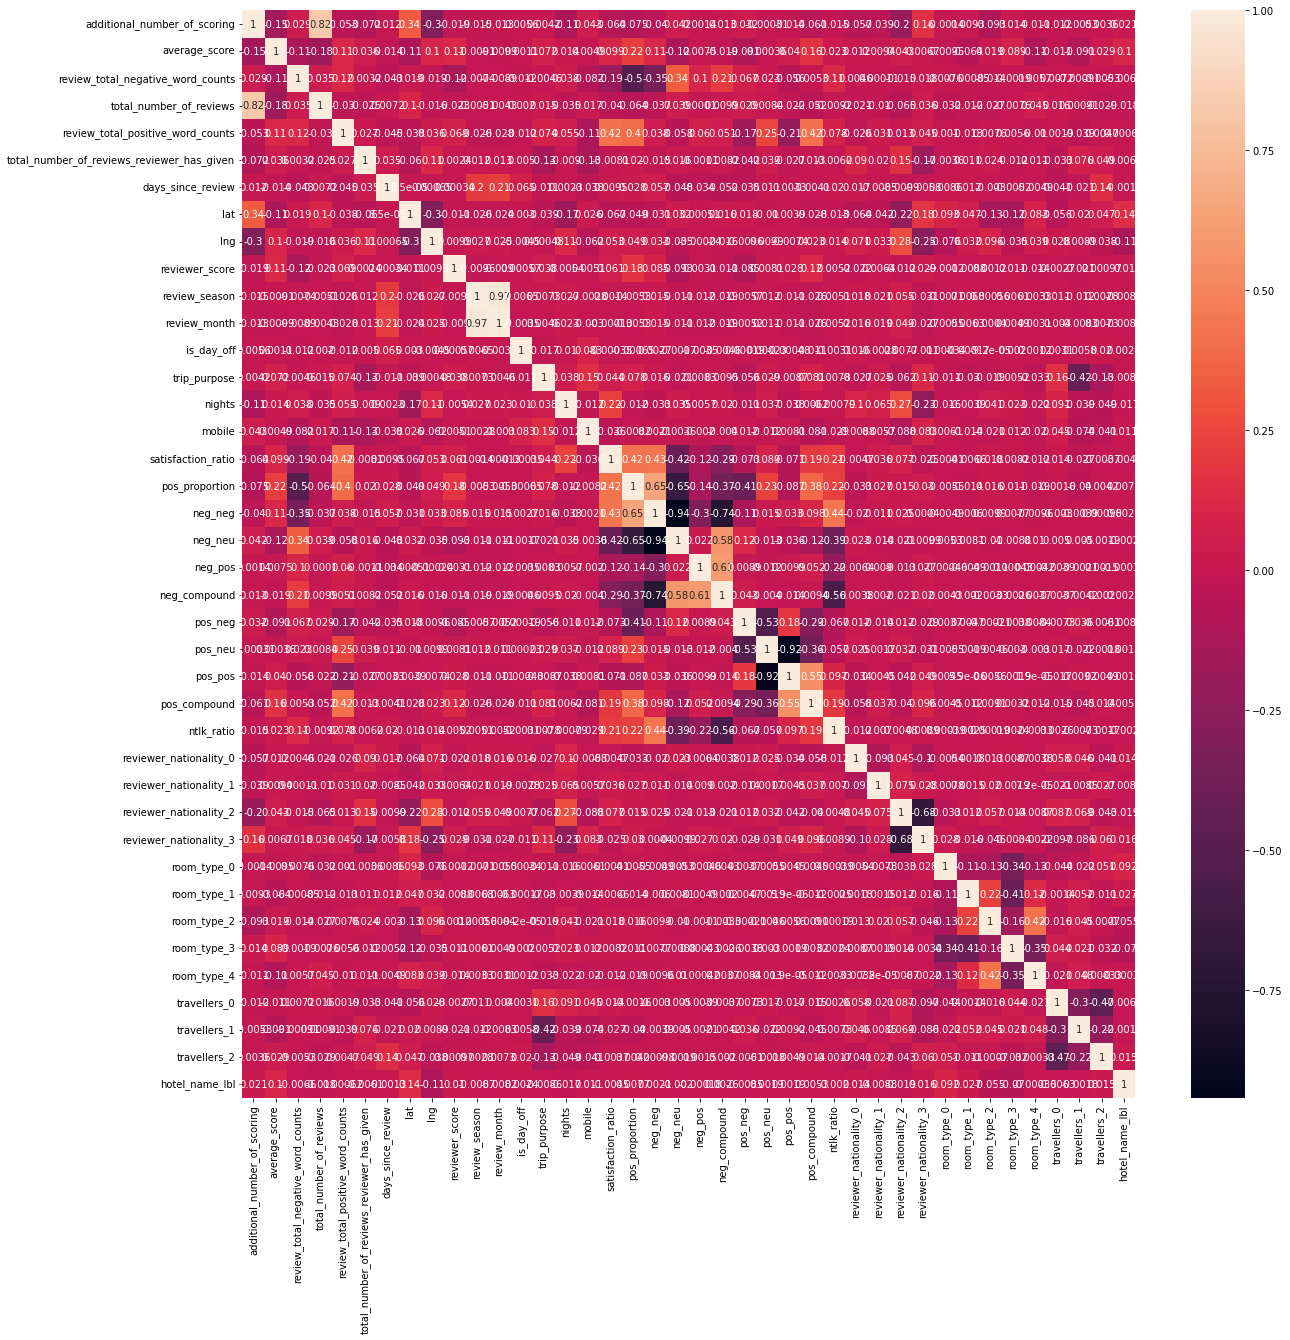

In [31]:
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

#### Очистим датасет от сильно коррелирующих признаков, на основании информации из матрицы корреляций.

In [32]:
data.drop(['neg_neu', 'pos_neu', 'neg_neg', 'additional_number_of_scoring', 'review_season'], axis = 1, inplace=True) # , 'total_negative_words'

<AxesSubplot:>

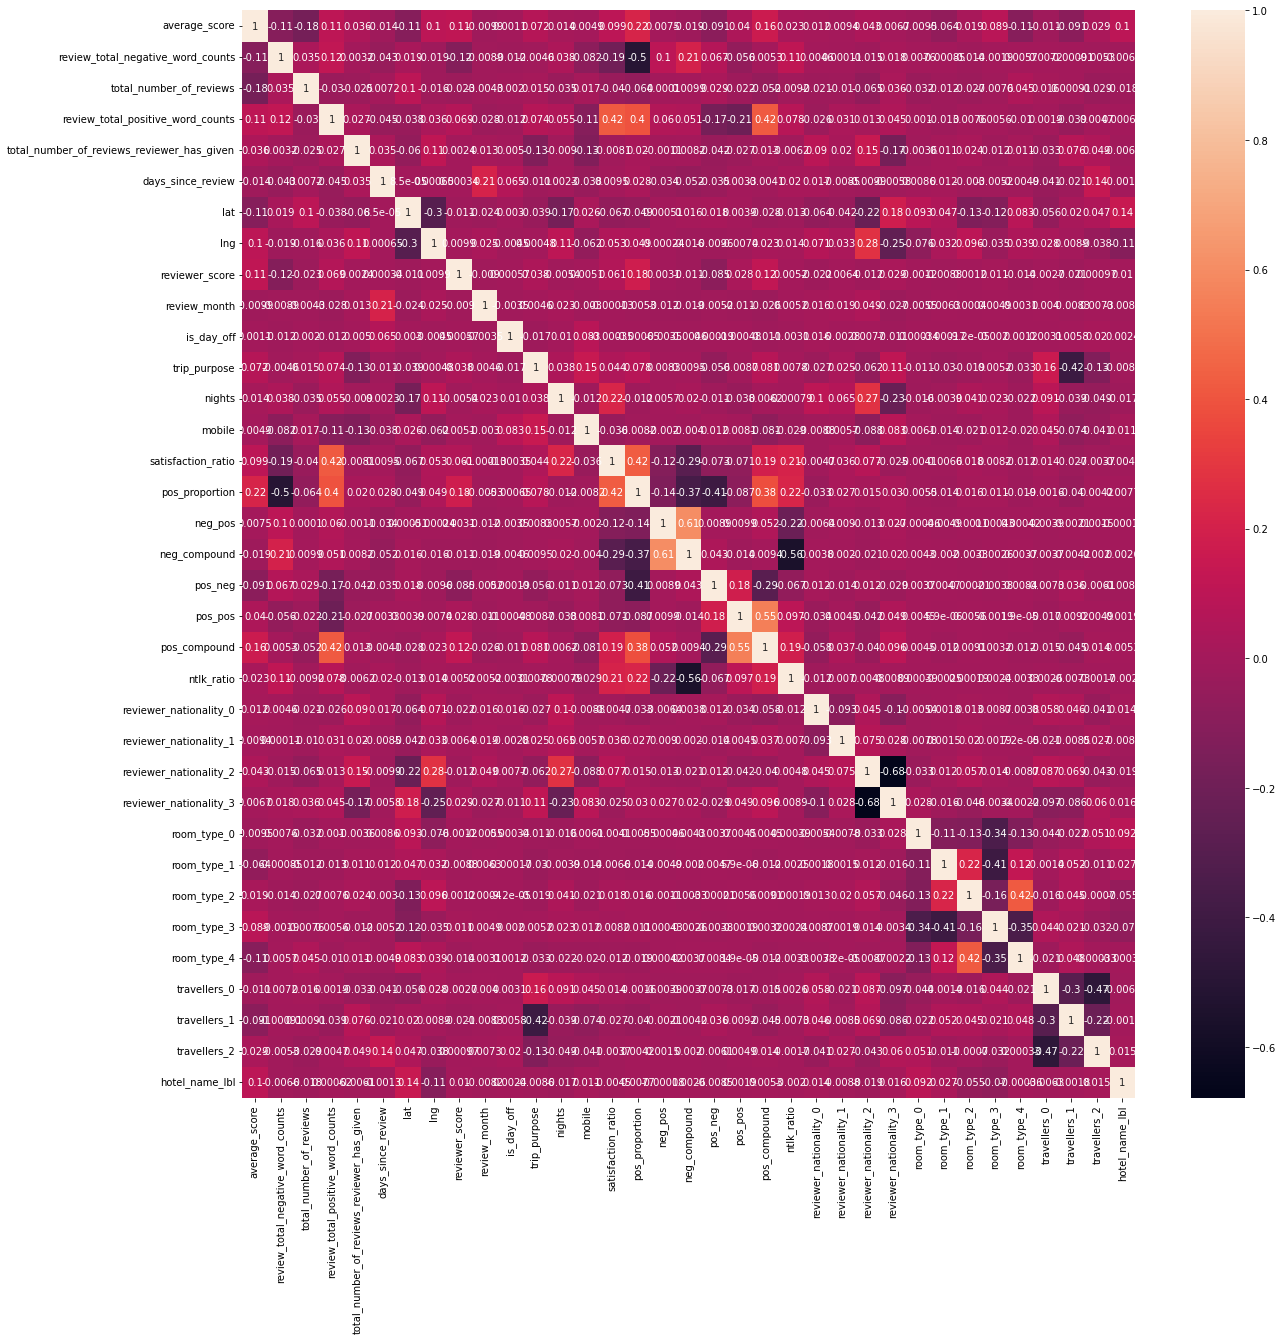

In [33]:
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 36 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   days_since_review                           515738 non-null  int64  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

In [35]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop([TARGET_NAME], axis=1)

In [36]:
# # непрерывные признаки
# num_cols = [
#     'average_score', 'review_total_negative_word_counts',
#     'review_total_positive_word_counts', 
#     'total_number_of_reviews_reviewer_has_given',
#     'days_since_review', 'lat', 'lng',
#     'satisfaction_ratio', 'satisfaction_actuality', 
#     'total_positive_words', 'pos_neg_ratio', 'neg_pos', 
#     'neg_compound', 'pos_neg', 'pos_compound'
    
#     ]

# # категориальные признаки
# cat_cols = [
#     'review_season', 'is_day_off',
#     'trip_purpose', 'nights', 'mobile',
#     'reviewer_nationality_0', 'reviewer_nationality_1',
#     'reviewer_nationality_2', 'reviewer_nationality_3', 
#     'reviewer_nationality_4', 'travellers_0', 
#     'travellers_1', 'travellers_2', 'travellers_3',
#     'room_type_0', 'room_type_1', 'room_type_2', 
#     'room_type_3', 'room_type_4', 'room_type_5'
    
#     ]

In [37]:
# y=y.astype('int')

# imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
# imp_cat.sort_values(inplace = True)
# imp_cat.plot(kind = 'barh')

In [38]:
# X.drop(['is_day_off', 'room_type_4', 'travellers_3', 'room_type_3', 'reviewer_nationality_4'], axis = 1, inplace=True) 
# test_data.drop(['is_day_off', 'room_type_4', 'travellers_3', 'room_type_3', 'reviewer_nationality_4'], axis = 1, inplace=True) 

In [39]:
# imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
# imp_num.sort_values(inplace = True)
# imp_num.plot(kind = 'barh')

In [40]:
# X.drop(['neg_pos', 'days_since_review', 'total_positive_words', 'lat', 'lng'], axis = 1, inplace=True) 
# test_data.drop(['neg_pos', 'days_since_review', 'total_positive_words', 'lat', 'lng'], axis = 1, inplace=True) 

In [41]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [42]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 35), (386803, 35), (386803, 34), (309442, 34), (77361, 34))

In [43]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [44]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [45]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


In [46]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8790380812037069
MAPE: 12.545053256828032


<AxesSubplot:>

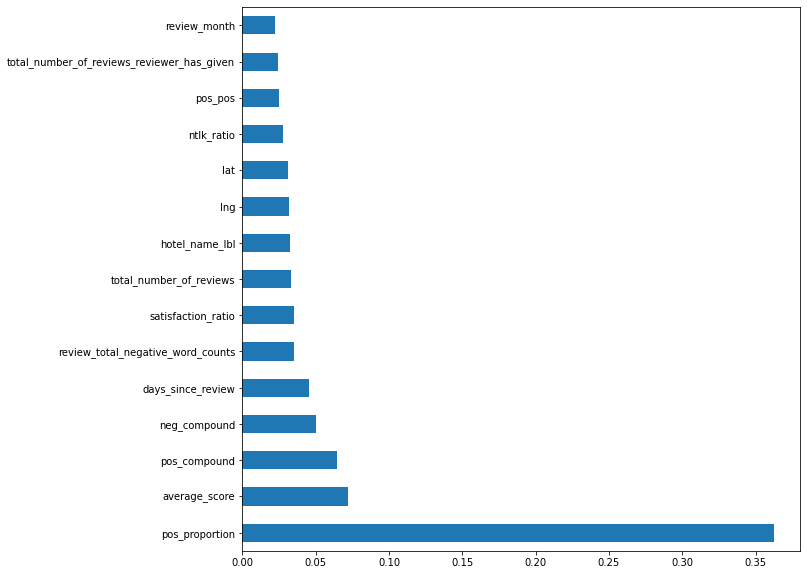

In [47]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [48]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,review_month,...,reviewer_nationality_3,room_type_0,room_type_1,room_type_2,room_type_3,room_type_4,travellers_0,travellers_1,travellers_2,hotel_name_lbl
77443,8.4,15,3222,0,6,73,41.389117,2.167199,0.0,5,...,0,0,0,0,1,0,0,0,1,96
96149,8.8,0,7371,3,27,235,45.483850,9.203407,0.0,12,...,0,0,1,0,0,0,0,1,1,347
56727,9.4,23,2200,36,5,660,51.504497,-0.085556,0.0,10,...,1,0,0,0,1,0,0,0,1,1247
96228,8.8,2,1693,11,3,15,41.392018,2.157066,0.0,7,...,1,0,0,0,1,0,0,0,1,480
51787,8.1,9,2312,13,2,300,51.526385,-0.113604,0.0,10,...,1,0,0,1,1,1,0,0,1,260
115905,8.0,15,3078,8,1,75,48.206227,16.383377,0.0,5,...,1,0,0,0,1,0,0,1,0,523
124365,8.8,0,807,43,4,392,41.375237,2.168406,0.0,7,...,1,0,0,1,0,1,0,0,1,582
36971,8.5,11,2601,9,23,213,45.479459,9.195143,0.0,1,...,0,0,0,0,1,0,0,1,0,1479
118791,8.5,2,1187,4,3,228,51.519032,-0.182594,0.0,12,...,1,0,0,0,1,0,0,1,1,1083
18296,7.1,104,1484,40,4,78,41.386052,2.176157,0.0,5,...,1,0,0,1,1,0,0,0,1,824


In [49]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [50]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [51]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished


In [52]:
predict_submission

array([8.675, 7.178, 8.088, ..., 8.19 , 9.63 , 7.307])

In [53]:
list(sample_submission)

['reviewer_score', 'id']

In [54]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_fin.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.675,488440
1,7.178,274649
2,8.088,374688
3,9.720,404352
4,9.530,451596
5,9.065,302161
6,7.626,317079
7,7.347,13963
8,8.857,159785
9,7.297,195089
